In [1]:
import sys, os, re, random, warnings, pickle
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from numpy.random import shuffle
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ssqa import *
from data import *
from pgm import *
from utils import *
from config import *

import sys

device = torch.device('cpu')
warnings.filterwarnings("ignore")
torch.cuda.is_available()

True

In [2]:
DATA = PFAM_DATA
DATASET = "PF00144"

batch_size = 300
q = 21
N = 31
k = 10
lamb_l1b = 0.025
gamma = lamb_l1b/(2*q*N)

## SS3 prediction

In [3]:
device = "cuda"
#DATA = PFAM_DATA

In [4]:
dataset = SSQAData_SSinf(f"{DATA}/{DATASET}/data.pt")
loader = DataLoader(dataset, batch_size = 1, 
                          shuffle = False, drop_last=False, collate_fn = collate_sequences)

Available :  seq L cluster_index weights subset seq_hmm pattern


In [8]:
N, q = 128, 50
# del model
# del model
model_ss = NetSurfP2(q, "nsp")
model_ss = model_ss.to(device)
optimizer = optim.Adam(model_ss.parameters(), lr=0.001)
model_ss.load_state_dict(torch.load(f"{UTILS}/nsp_50feats.h5"))

ss3 = torch.zeros(len(dataset), 3, 500)
for batch_idx, data in enumerate(loader):
    x = torch.tensor(data[0]).float().cuda()
    ss_ = F.softmax(model_ss(x)[2],1).detach().cpu()
    ss3[1*batch_idx:1*(batch_idx+1), :, :ss_.size(-1)] = ss_
    if batch_idx == 1000:
        break

model_ss

Model nsp-50

In [9]:
seq_df = pd.read_csv(f"{DATA}/{DATASET}/sequences.csv")

In [71]:
dataset.seqs.shape

torch.Size([3893, 20, 1556])

In [77]:
n_min, n_max = 200, 300
ss3m = ss3.permute(0, 2, 1)

In [87]:
ss3m[i, :, :len(nnz)].shape

torch.Size([500, 3])

           Unnamed: 0                                        aligned_seq  \
91  A0A1I2IMA6/54-384  LDAAARRAVA-----DGEV-PG-L-A----------------V-G-...   
19   A7SA90/1322-1633  -QDLISQEIR-----QGKA-TA-V-S----------------A-S-...   
60      Q18384/50-404  FRRNFTEGWE--------K-AG-A-A----------------F-C-...   

                                                  seq  length  
91  LDAAARRAVADGEVPGLAVGVVRQGRLVFSRGFGSADLEQGTRITP...     331  
19  QDLISQEIRQGKATAVSASLVYRDEVVWSGGFGVMDKSANPPVPPT...     312  
60  FRRNFTEGWEKAGAAFCVIHKGKVIVDLWGGYADKECFKEWKEDTI...     355  


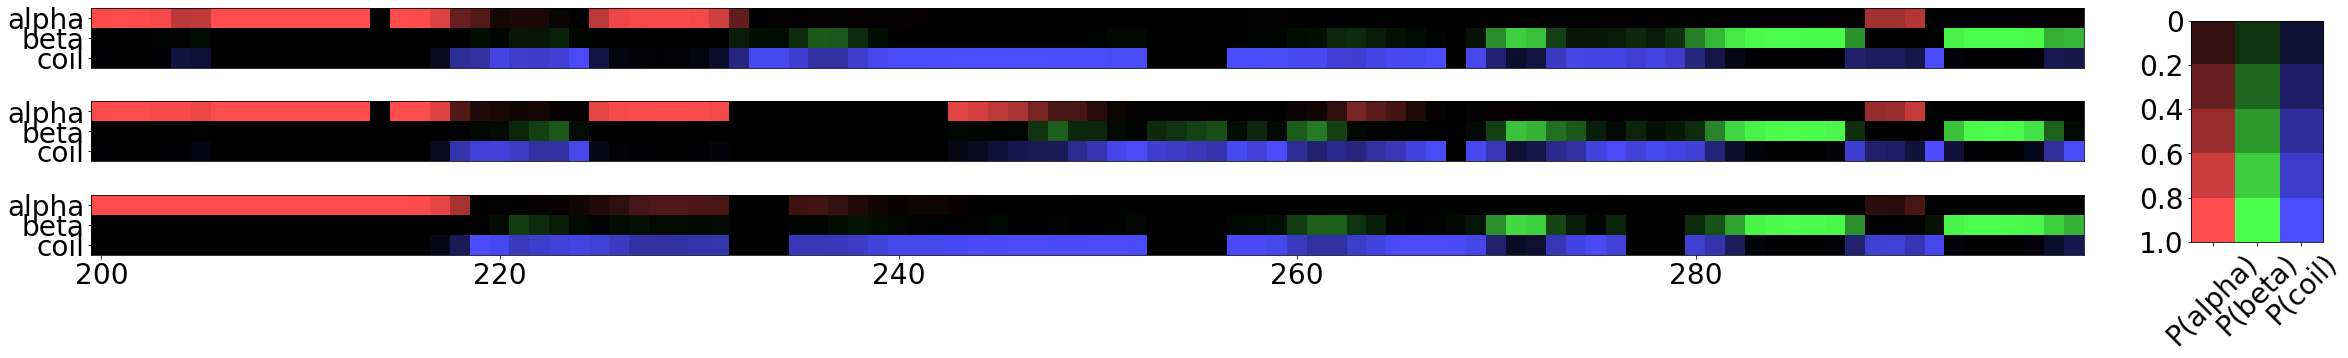

In [100]:
from matplotlib import gridspec 

def to_map(pot, k):
    mapping = np.ones((pot.shape[0],3))
    r,g,b = colors[k]
    p = pot[:,k]
    mapping[:,0] = r*p
    mapping[:,1] = g*p
    mapping[:,2] = b*p
    return mapping
fig = plt.figure(figsize= (40,5))

def color_map(k):
    mapping = np.ones((5,3))
    r,g,b = colors[k]
    for i, p in enumerate([0.2,0.4,0.6,0.8,1]):
        mapping[i,0] = r*p
        mapping[i,1] = g*p
        mapping[i,2] = b*p
    return mapping

colors = [(1,0.3,0.3),
          (0.3,1,0.3), 
          (0.3,0.3,1), 
          (0.7,0.2,0.4), 
          (0.7,0.2,0.8), 
          (0.7,1,0), 
          (0,0,1), 
          (0,0.8,1)]


spec = gridspec.GridSpec(ncols=2, nrows=3, 
                         width_ratios=[15, 1], wspace=0.1, 
                         hspace=0.1, height_ratios=[1,1,1]) 


SIZE = 100
#idxs = np.random.choice(100, 3)
aligned_struct = torch.zeros(3,dataset.seqs.size(-1), 3)
for nrow, i in enumerate(idxs):
    nnz = torch.where(dataset.seqs[i].sum(0) != 0)[0]
    aligned_struct[nrow, nnz, :] = ss3m[i, :len(nnz),]

nnz = torch.where(aligned_struct.sum(0).sum(-1) != 0)[0]
aligned_struct = aligned_struct[:, nnz]
aligned_struct = aligned_struct[:, 275:375]
for nrow in range(3):
#     gt = np.array(val_dataset[i][2][:,-1],dtype=int)
    N = aligned_struct[nrow].shape[0]
    q, r = N//SIZE, N%SIZE
    j = 0
    p = np.pad(aligned_struct[nrow], ((0,(SIZE-r)%SIZE),(0,0)))
    mapping = np.array([to_map(p,i) for i in range(3)])
    ax = fig.add_subplot(spec[nrow,0]) 
    if nrow != 2:
        plt.xticks([],[])
    else:
        plt.xticks([0, 20, 40, 60, 80, 100], [200, 220, 240, 260, 280, 300], fontsize = 28)
    plt.yticks([0,1,2],["alpha", "beta", "coil"], fontsize = 28)
    ax.imshow(mapping)

print(seq_df.iloc[idxs])
ax1 = fig.add_subplot(spec[:,1]) 
ax1.imshow(np.concatenate([color_map(0)[:,None], color_map(1)[:,None], color_map(2)[:,None]],1))
plt.yticks([-0.5,0.5,1.5,2.5,3.5,4.5],[0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 28)
plt.xticks([0, 1, 2],["P(alpha)", "P(beta)", "P(coil)"], rotation = 45, fontsize = 28)

plt.show()

In [106]:
len(nnz)

390